In [168]:
import os
import shutil
from os import listdir

import cv2

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Dropout, LSTM, Bidirectional, Dense, Activation
from tensorflow import keras
from keras import backend
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

### 1. Read the parase.txt file containing the image id and the respective word for that image and take the first 10000 instances for training and testing of the model

In [3]:
if not os.path.exists('image_df.csv'):
    counter = 0
    image_df = pd.DataFrame()
    with open('parser.txt', mode='r') as f:
        while counter < 10000:
            image_df = pd.concat([image_df, pd.DataFrame(f.readline().split()).T], axis=0)
            counter+=1
    image_df.to_csv('image_df.csv', index=False)
else:
    image_df = pd.read_csv('image_df.csv')

In [4]:
print(f"Shape of the image dataframe: {image_df.shape}")

Shape of the image dataframe: (10000, 10)


In [5]:
df = image_df.copy()

In [6]:
df.head()

,0,1,2,3,4,5,6,7,8,9
0,a01-000u-00-00,ok,154,408,768,27,51,AT,A,NaN
1,a01-000u-00-01,ok,154,507,766,213,48,NN,MOVE,NaN
2,a01-000u-00-02,ok,154,796,764,70,50,TO,to,NaN
3,a01-000u-00-03,ok,154,919,757,166,78,VB,stop,NaN
4,a01-000u-00-04,ok,154,1185,754,126,61,NPT,Mr.,NaN


In [7]:
# Drop of unwanted columns
df = df[['0','8']]
df.head()

,0,8
0,a01-000u-00-00,A
1,a01-000u-00-01,MOVE
2,a01-000u-00-02,to
3,a01-000u-00-03,stop
4,a01-000u-00-04,Mr.


In [8]:
# renaming the columns
df.columns = ['Image_Id', 'Word']
df = df.set_index('Image_Id')
df.head()

,Word
Image_Id,
a01-000u-00-00,A
a01-000u-00-01,MOVE
a01-000u-00-02,to
a01-000u-00-03,stop
a01-000u-00-04,Mr.


In [9]:
# copy the images to a particular folder if it is empty

source_path = 'words\words'
dest_path = 'dataset'

if len(listdir(dest_path)) != 10000:

    for image_id in df.index.values:
        metadata = image_id.split('-')
        folder = metadata[0]
        sub_folder = folder+'-'+metadata[1]
        file_name = image_id+'.png'
        full_path = os.path.join(source_path, folder, sub_folder, file_name)
        shutil.copyfile(full_path, os.path.join(dest_path, file_name))
else:
    print('This path already has all the files')

This path already has all the files


### 2. Images can be of different shape thus resize all your images to have same shape (for example = (128, 32))

In [10]:
df['Image_Path'] = dest_path+'\\'+ df.index+'.png'
df.head()

,Word,Image_Path
Image_Id,,
a01-000u-00-00,A,dataset\a01-000u-00-00.png
a01-000u-00-01,MOVE,dataset\a01-000u-00-01.png
a01-000u-00-02,to,dataset\a01-000u-00-02.png
a01-000u-00-03,stop,dataset\a01-000u-00-03.png
a01-000u-00-04,Mr.,dataset\a01-000u-00-04.png


In [11]:
# Load the images to a dataset

In [12]:
df['Image'] = None

In [13]:
Images = []
for index in df.index:
    image_path = df.at[index, 'Image_Path']
    image = cv2.imread(image_path, 0)
    if image is not None:
        try:
            result = cv2.resize(image, (32,128))            
        except Exception as e:
            result = np.zeros((32,128))
    else:
        result = np.zeros((32,128))
        print(f'Failed to load {image_path}')
    result = result.reshape(32, 128)
    Images.append(result)
    df.at[index, 'Image'] = result

Failed to load dataset\a01-117-05-02.png


In [14]:
Images = np.array(Images)
print(f'Shape of Images: {Images.shape}')

Shape of Images: (10000, 32, 128)


In [15]:
def prod(val) : 
    res = 1 
    for ele in val: 
        res *= ele 
    return res 

In [16]:
df['Image'].apply(lambda x: prod(x.shape)).min()

4096

In [17]:
df.head()

,Word,Image_Path,Image
Image_Id,,,
a01-000u-00-00,A,dataset\a01-000u-00-00.png,"[[249, 249, 247, 235, 202, 148, 117, 88, 100, ..."
a01-000u-00-01,MOVE,dataset\a01-000u-00-01.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
a01-000u-00-02,to,dataset\a01-000u-00-02.png,"[[251, 250, 244, 209, 128, 236, 250, 251, 251,..."
a01-000u-00-03,stop,dataset\a01-000u-00-03.png,"[[255, 255, 255, 255, 255, 255, 255, 252, 111,..."
a01-000u-00-04,Mr.,dataset\a01-000u-00-04.png,"[[242, 167, 251, 251, 251, 251, 251, 251, 251,..."


In [18]:
def show_image(image):
    plt.imshow(image.reshape(32,128))
    plt.show()

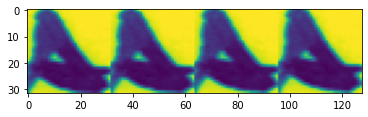

In [19]:
show_image(df['Image'][0])

In [20]:
df_copy = df.copy()
#df = df_copy

In [21]:
#df['Image'] = df['Image'].apply(lambda x: x.reshape(-1,1))

In [22]:
mms = MinMaxScaler(feature_range=(0,1))

df['Image'] = df['Image'] / 255
df.head()

,Word,Image_Path,Image
Image_Id,,,
a01-000u-00-00,A,dataset\a01-000u-00-00.png,"[[0.9764705882352941, 0.9764705882352941, 0.96..."
a01-000u-00-01,MOVE,dataset\a01-000u-00-01.png,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
a01-000u-00-02,to,dataset\a01-000u-00-02.png,"[[0.984313725490196, 0.9803921568627451, 0.956..."
a01-000u-00-03,stop,dataset\a01-000u-00-03.png,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882352..."
a01-000u-00-04,Mr.,dataset\a01-000u-00-04.png,"[[0.9490196078431372, 0.6549019607843137, 0.98..."


### 3. Currently, the pixel values are between 0 to 255, normalize the images so that the pixel values are in range 0 to 1 

In [23]:
Images = Images / 255

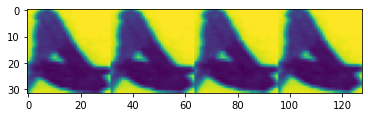

In [24]:
show_image(df['Image'][0])

### 4. Create a list of all characters and use the characters's index to encode the actual words into digits

In [25]:
characters = sorted(list(set(''.join(df['Word']))))
characters = dict(zip(characters, range(len(characters))))
#characters

In [26]:
le = LabelEncoder()
le.fit(list(characters.keys()))

LabelEncoder()

In [27]:
le.transform(['A','B'])

array([22, 23], dtype=int64)

### 5. Pad all the words to have a similar length

In [28]:
# Finding the maximum length of a word
maximum_word_length = df['Word'].str.len().max()
print(maximum_word_length)

18


In [29]:
def transform_word_to_array(word):
    if not word:
        return np.zeros(maximum_word_length)
    
    word_char = le.transform(list(word))
    result = np.pad(word_char, (0, maximum_word_length - len(word_char)), 'constant', constant_values=(0, 0))
    return result

In [30]:
df['target'] = df['Word'].apply(transform_word_to_array)
df.head()

,Word,Image_Path,Image,target
Image_Id,,,,
a01-000u-00-00,A,dataset\a01-000u-00-00.png,"[[0.9764705882352941, 0.9764705882352941, 0.96...","[22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
a01-000u-00-01,MOVE,dataset\a01-000u-00-01.png,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[34, 36, 43, 26, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
a01-000u-00-02,to,dataset\a01-000u-00-02.png,"[[0.984313725490196, 0.9803921568627451, 0.956...","[67, 62, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
a01-000u-00-03,stop,dataset\a01-000u-00-03.png,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9882352...","[66, 67, 62, 63, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
a01-000u-00-04,Mr.,dataset\a01-000u-00-04.png,"[[0.9490196078431372, 0.6549019607843137, 0.98...","[34, 65, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."


### 6. Split your dataset for training and testing

In [31]:
print(df['Image'].apply(lambda x: prod(x.shape)).min())
print(df['target'].apply(lambda x: prod(x.shape)).max())

4096
18


In [32]:
target = []
for value in df['target'].to_numpy():
    target.append(value)
target = np.array(target)
print(target.shape)

(10000, 18)


In [33]:
X = Images
y = target

print(f'Shape of X is {X.shape}')
print(f'Shape of y is {y.shape}')

Shape of X is (10000, 32, 128)
Shape of y is (10000, 18)


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Shape of X_train is {X_train.shape}')
print(f'Shape of X_test is {X_test.shape}')
print(f'Shape of y_train is {y_train.shape}')
print(f'Shape of y_test is {y_test.shape}')

Shape of X_train is (8000, 32, 128)
Shape of X_test is (2000, 32, 128)
Shape of y_train is (8000, 18)
Shape of y_test is (2000, 18)


In [35]:
X_train.shape, y_train.shape

((8000, 32, 128), (8000, 18))

In [116]:
X_train_rescaled = X_train.reshape(-1, 128, 32, 1)
image_width, image_height = X_train[0].shape[1], X_train[0].shape[0]
new_shape = (image_width//4, (image_height // 4) * 64 )

model = keras.Sequential([
    #layers.Rescaling(1./255),
    layers.Input(shape=(image_width, image_height, 1)),
    layers.Conv2D(filters=32, 
                  kernel_size=3, 
                  activation='relu', 
                  kernel_initializer='he_normal', 
                  padding='same',
                  input_shape = X_train_rescaled[0].shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(filters=64, 
                  kernel_size=3, 
                  activation='relu', 
                  kernel_initializer='he_normal', 
                  padding='same'),
    layers.MaxPool2D((2,2)),
    
    layers.Reshape(target_shape = new_shape),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    
    layers.Bidirectional(LSTM(128, return_sequences=True, dropout=0.25)),
    layers.Bidirectional(LSTM(64, return_sequences=True, dropout=0.25)),
    layers.Dense(len(characters.keys()), activation='softmax'),
])

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics= ['accuracy'])
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 128, 32, 32)       320       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 64, 16, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 64, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 32, 8, 64)         0         
_________________________________________________________________
reshape_16 (Reshape)         (None, 32, 512)           0         
_________________________________________________________________
dense_35 (Dense)             (None, 32, 64)            32832     
_________________________________________________________________
dropout_9 (Dropout)          (None, 32, 64)          

In [117]:
model.fit(X_train_rescaled, y_train, epochs=1)

ValueError: in user code:

    C:\Users\vlekkala\Anaconda3\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    C:\Users\vlekkala\Anaconda3\lib\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\vlekkala\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\vlekkala\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\vlekkala\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\vlekkala\Anaconda3\lib\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    C:\Users\vlekkala\Anaconda3\lib\site-packages\keras\engine\training.py:788 train_step
        loss = self.compiled_loss(
    C:\Users\vlekkala\Anaconda3\lib\site-packages\keras\engine\compile_utils.py:201 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\vlekkala\Anaconda3\lib\site-packages\keras\losses.py:141 __call__
        losses = call_fn(y_true, y_pred)
    C:\Users\vlekkala\Anaconda3\lib\site-packages\keras\losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\vlekkala\Anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\vlekkala\Anaconda3\lib\site-packages\keras\losses.py:1665 categorical_crossentropy
        return backend.categorical_crossentropy(
    C:\Users\vlekkala\Anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\vlekkala\Anaconda3\lib\site-packages\keras\backend.py:4839 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    C:\Users\vlekkala\Anaconda3\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (32, 18) and (32, 32, 74) are incompatible


In [127]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred

In [132]:
def build_model1():
    optimizer_name = 'Adam'
    
    input_img = keras.Input(shape=(image_width, image_height, 1), name = 'input_image')
    labels = keras.layers.Input(name='label', shape=(None, ))
    
    x = keras.layers.Conv2D(32,
                           (3,3),
                           activation='relu',
                           kernel_initializer='he_normal',
                            padding='same',
                            name='Conv1')(input_img)
    x = keras.layers.MaxPool2D((2,2), name='pool1')(x)
    
    x = keras.layers.Conv2D(64, 
                           (3,3),
                           activation='relu',
                           kernel_initializer = 'he_normal',
                           padding='same',
                           name='Conv2')(x)
    x = keras.layers.MaxPool2D((2,2), name='pool2')(x)
    
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    
    x = keras.layers.Reshape(target_shape = new_shape, name = 'reshape')(x)
    x = keras.layers.Dense(64, activation='relu', name = 'dense1')(x)
    x = keras.layers.Dropout(0.2)(x)
    
    x = keras.layers.Bidirectional(
            keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    
    x = keras.layers.Bidirectional(
            keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)
    
    x = keras.layers.Dense(
        len(characters.keys()) + 1, activation='softmax', name='dense2'
    )(x)
        
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model

    

In [157]:
optimizer_name = 'Adam'

input_img = keras.Input(shape=(image_width, image_height, 1), name = 'input_image')
labels = keras.layers.Input(name='label', shape=(None, ))

x = keras.layers.Conv2D(32,
                       (3,3),
                       activation='relu',
                       kernel_initializer='he_normal',
                        padding='same',
                        name='Conv1')(input_img)
x = keras.layers.MaxPool2D((2,2), name='pool1')(x)

x = keras.layers.Conv2D(64, 
                       (3,3),
                       activation='relu',
                       kernel_initializer = 'he_normal',
                       padding='same',
                       name='Conv2')(x)
x = keras.layers.MaxPool2D((2,2), name='pool2')(x)

new_shape = ((image_width // 4), (image_height // 4) * 64)

x = keras.layers.Reshape(target_shape = new_shape, name = 'reshape')(x)
x = keras.layers.Dense(64, activation='relu', name = 'dense1')(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
)(x)

x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
)(x)

x = keras.layers.Dense(
    len(characters.keys()) + 1, activation='softmax', name='dense2'
)(x)
    
y_pred = Activation('softmax', name='softmax')(x)    
model = keras.Model(inputs = input_img, outputs = y_pred)    
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 128, 32, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 128, 32, 32)       320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 64, 16, 32)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 64, 16, 64)        18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 32, 8, 64)         0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 512)           0         
_________________________________________________________________
dense1 (Dense)               (None, 32, 64)            3283

In [177]:
train_size = X_train.shape[0]
train_size

8000

In [184]:
num_of_timestamps = 64
train_label_len = df['Word'].str.len().to_numpy().reshape(-1,1)
train_input_len = np.ones([train_size, 1])*(num_of_timestamps - 2)
train_output = np.zeros([train_size])

In [163]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [165]:
labels = keras.Input(name='gtruth_labels', shape=[maximum_word_length], dtype='float32')
input_length = keras.Input(name='input_length', shape=[1], dtype='int64')
label_length = keras.Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = layers.Lambda(ctc_lambda_func, output_shape = (1, ), name='ctc')([y_pred, labels, input_length, label_length])
model_final = keras.Model(inputs=[input_img, labels, input_length, label_length], outputs = ctc_loss)

In [175]:
# Train out model

model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='Adam')

model_final.fit(x=[X_train_rescaled, y_train, input_length, label_length])

ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'keras.engine.keras_tensor.KerasTensor'>", "<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>", "<class 'numpy.ndarray'>"}), <class 'NoneType'>

In [174]:
tf.data.Dataset.from_tensor_slices(X_train_rescaled)

<TensorSliceDataset shapes: (128, 32, 1), types: tf.float64>

In [142]:
np.ones([10, 1])

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])